In [1]:
from lib.abstract_torch import get_device
from lib.dataloader import get_task_loaders
from lib.models import ANN
from lib.growth_schedules import get_CL_schedule
from lib.train import train
from lib.test import test
from lib.visualize import visualize_accs_matrix, visualize_avg_acc_curve

import os
import numpy as np

In [2]:
train_vanilla = True

In [3]:
device = get_device()

In [4]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "/data"

In [5]:
# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden_root = 10
num_hidden_target = 100
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

# Hyperparameters
num_epochs = 3
lr = 5e-3

## Reproducibility

In [6]:
random_seed = 88
permutation_random_seeds = list(range(10))

## Get p-MNIST loaders

In [7]:
train_loaders_list, val_loaders_list, test_loaders_list = [], [], []
for random_seed in permutation_random_seeds :
    train_loader, val_loader, test_loader = get_task_loaders(data_path, batch_size, random_seed, train_percentage=0.2, download=False)
    train_loaders_list += [train_loader]
    val_loaders_list += [val_loader]
    test_loaders_list += [test_loader]

## Grow from root model

In [8]:
# Growth parameters
num_neurons = 9
init_name = "gradmax"

In [9]:
growth_schedule = get_CL_schedule(num_neurons)

In [10]:
# Define root model
root_model = ANN(num_inputs, num_hidden_root, num_outputs, random_seed).to(device)

# Train root model on task 0
_ = train(root_model, None, loss_name, optimizer_name, lr, train_loaders_list[0], None, num_epochs, batch_size, device, random_seed)

  0%|          | 0/3 [00:00<?, ?it/s]

grad : tensor([ 0.0002, -0.0017,  0.0002,  0.0002,  0.0002,  0.0002,  0.0002,  0.0002,
         0.0002,  0.0002], device='cuda:0')


 33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

grad : tensor([ 0.0002,  0.0002,  0.0002,  0.0002,  0.0002,  0.0002,  0.0001,  0.0002,
         0.0002, -0.0017], device='cuda:0')


 67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

grad : tensor([ 9.2772e-05,  6.2976e-05,  1.6807e-04,  1.0807e-04, -9.9718e-04,
         1.3620e-04,  2.1836e-04,  1.0622e-04,  1.8893e-04,  1.5404e-04],
       device='cuda:0')


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


In [11]:
# Initialize the matrix containing test accuracies on various task
test_accs_matrix = np.zeros((10,10))
for j in range(10) :
    test_accs_matrix[0,j] = round(test(root_model, test_loaders_list[j], batch_size, device),2)

# Train & grow the root model on the other tasks
for i in range(1,10) :
    print("Task :", i)
    train_loader = train_loaders_list[i]
    _= train(root_model,
             growth_schedule,
             loss_name, optimizer_name, lr, 
             train_loader, None, 
             num_epochs, batch_size, 
             device, random_seed,
             init_name=init_name,
             verbose=2)
    for j in range(10) :
        test_accs_matrix[i,j] = round(test(root_model, test_loaders_list[j], batch_size, device),2)



Task : 1


  0%|          | 0/3 [00:00<?, ?it/s]

Number of neurons on epoch 0, before batch 9:
fc1 : in = 784, out = 19
fc2 : in = 19, out = 10
fc3 : in = 10, out = 10
Number of neurons on epoch 0, before batch 18:
fc1 : in = 784, out = 19
fc2 : in = 19, out = 19
fc3 : in = 19, out = 10


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Task : 2


  0%|          | 0/3 [00:00<?, ?it/s]

Number of neurons on epoch 0, before batch 9:
fc1 : in = 784, out = 28
fc2 : in = 28, out = 19
fc3 : in = 19, out = 10
Number of neurons on epoch 0, before batch 18:
fc1 : in = 784, out = 28
fc2 : in = 28, out = 28
fc3 : in = 28, out = 10


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


Task : 3


  0%|          | 0/3 [00:00<?, ?it/s]

Number of neurons on epoch 0, before batch 9:
fc1 : in = 784, out = 37
fc2 : in = 37, out = 28
fc3 : in = 28, out = 10
Number of neurons on epoch 0, before batch 18:
fc1 : in = 784, out = 37
fc2 : in = 37, out = 37
fc3 : in = 37, out = 10


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


Task : 4


  0%|          | 0/3 [00:00<?, ?it/s]

Number of neurons on epoch 0, before batch 9:
fc1 : in = 784, out = 46
fc2 : in = 46, out = 37
fc3 : in = 37, out = 10
Number of neurons on epoch 0, before batch 18:
fc1 : in = 784, out = 46
fc2 : in = 46, out = 46
fc3 : in = 46, out = 10


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Task : 5


  0%|          | 0/3 [00:00<?, ?it/s]

Number of neurons on epoch 0, before batch 9:
fc1 : in = 784, out = 55
fc2 : in = 55, out = 46
fc3 : in = 46, out = 10
Number of neurons on epoch 0, before batch 18:
fc1 : in = 784, out = 55
fc2 : in = 55, out = 55
fc3 : in = 55, out = 10


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


Task : 6


  0%|          | 0/3 [00:00<?, ?it/s]

Number of neurons on epoch 0, before batch 9:
fc1 : in = 784, out = 64
fc2 : in = 64, out = 55
fc3 : in = 55, out = 10
Number of neurons on epoch 0, before batch 18:
fc1 : in = 784, out = 64
fc2 : in = 64, out = 64
fc3 : in = 64, out = 10


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


Task : 7


  0%|          | 0/3 [00:00<?, ?it/s]

Number of neurons on epoch 0, before batch 9:
fc1 : in = 784, out = 73
fc2 : in = 73, out = 64
fc3 : in = 64, out = 10
Number of neurons on epoch 0, before batch 18:
fc1 : in = 784, out = 73
fc2 : in = 73, out = 73
fc3 : in = 73, out = 10


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


Task : 8


  0%|          | 0/3 [00:00<?, ?it/s]

Number of neurons on epoch 0, before batch 9:
fc1 : in = 784, out = 82
fc2 : in = 82, out = 73
fc3 : in = 73, out = 10
Number of neurons on epoch 0, before batch 18:
fc1 : in = 784, out = 82
fc2 : in = 82, out = 82
fc3 : in = 82, out = 10


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Task : 9


  0%|          | 0/3 [00:00<?, ?it/s]

Number of neurons on epoch 0, before batch 9:
fc1 : in = 784, out = 91
fc2 : in = 91, out = 82
fc3 : in = 82, out = 10
Number of neurons on epoch 0, before batch 18:
fc1 : in = 784, out = 91
fc2 : in = 91, out = 91
fc3 : in = 91, out = 10


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


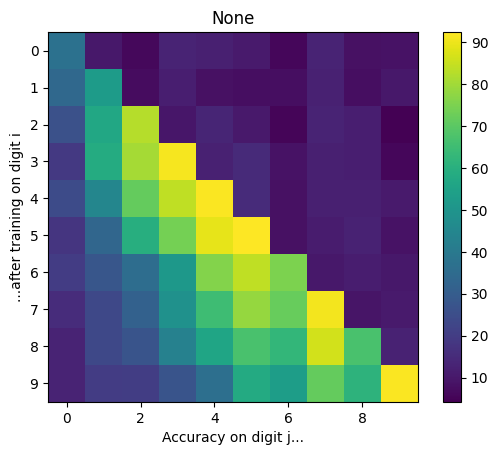

In [12]:
visualize_accs_matrix(test_accs_matrix)

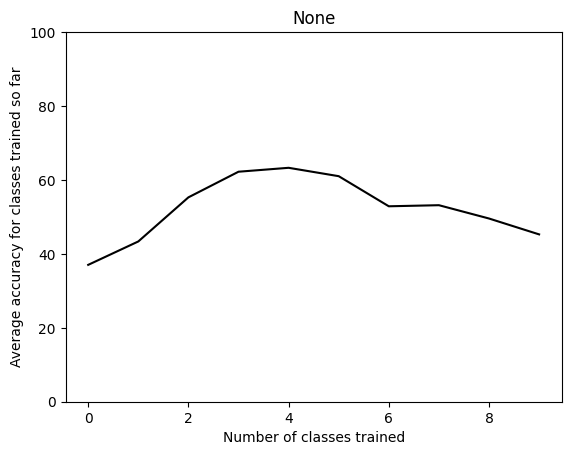

In [13]:
visualize_avg_acc_curve(test_accs_matrix)